# Libs

In [ ]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import time

In [ ]:
# Download required resources
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Read

In [ ]:
tweets = pd.read_csv('Tweets.csv')

In [ ]:
tweets

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [ ]:
tweets = tweets.dropna(subset=['text'])

In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


# Data pre process


In [ ]:
# Text Preprocessing
def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    words = text.split()
    words = [w for w in words if w not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]  # Lemmatization
    return ' '.join(words)

tweets['clean_text'] = tweets['selected_text'].astype(str).apply(clean_text)


<ipython-input-8-8c3ffa3c66f7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['clean_text'] = tweets['selected_text'].astype(str).apply(clean_text)


# Vader

<ipython-input-9-d2a0fbcdef0f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['vader_score'] = tweets['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
<ipython-input-9-d2a0fbcdef0f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['vader_sentiment'] = tweets['vader_score'].apply(get_vader_sentiment)


Accuracy: 0.6374818049490538
Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.63      0.68      7781
     neutral       0.62      0.48      0.54     11117
    positive       0.59      0.85      0.70      8582

    accuracy                           0.64     27480
   macro avg       0.65      0.65      0.64     27480
weighted avg       0.65      0.64      0.63     27480



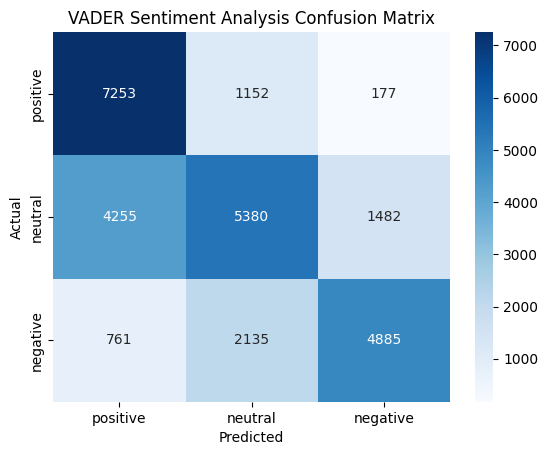

In [ ]:
# Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
tweets['vader_score'] = tweets['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

def get_vader_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

tweets['vader_sentiment'] = tweets['vader_score'].apply(get_vader_sentiment)

# Evaluation
y_true = tweets['sentiment']
y_pred = tweets['vader_sentiment']

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("VADER Sentiment Analysis Confusion Matrix")
plt.show()


Common failure cases:
1. Sarcasm: VADER struggles to detect sarcasm, leading to misclassification.
2. Context Dependence: Words with different meanings in different contexts may be misclassified.
3. Negations & Intensifiers: Phrases like 'not bad' can be misinterpreted.

In [ ]:
# Analysis of VADER Failures
failed_cases = tweets[(tweets['vader_sentiment'] != tweets['sentiment'])]
print("Examples where VADER fails:")
print(failed_cases[['selected_text', 'sentiment', 'vader_sentiment']].head(10))

Examples where VADER fails:
                                        selected_text sentiment  \
4                                       Sons of ****,  negative   
5   http://www.dothebouncy.com/smf - some shameles...   neutral   
10  as much as i love to be hopeful, i reckon the ...   neutral   
15                              Uh oh, I am sunburned  negative   
16                                             *sigh*  negative   
18                                               onna  negative   
20  oh Marly, I`m so sorry!!  I hope you find her ...   neutral   
23  gotta restart my computer .. I thought Win7 wa...   neutral   
24  SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...   neutral   
27                                       .no internet  negative   

   vader_sentiment  
4          neutral  
5         positive  
10        positive  
15         neutral  
16         neutral  
18         neutral  
20        positive  
23        positive  
24        negative  
27         neutral  

Co

# PreProcess For Models

## Tokenization & Padding & encoding 

In [ ]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets['clean_text'])
sequences = tokenizer.texts_to_sequences(tweets['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')

# Encode Sentiment Labels
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
tweets['sentiment_encoded'] = tweets['sentiment'].map(sentiment_mapping)

<ipython-input-13-92f0ee086401>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['sentiment_encoded'] = tweets['sentiment'].map(sentiment_mapping)


## Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, tweets['sentiment_encoded'], test_size=0.2, random_state=42)

# Models 

choosing best hyperparameters for each 

In [ ]:
# Hyperparameter Optimization
def build_model(model_type, embedding_dim, hidden_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=50))
    if model_type == 'RNN':
        model.add(SimpleRNN(hidden_units, return_sequences=False))
    elif model_type == 'LSTM':
        model.add(LSTM(hidden_units, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(hidden_units, return_sequences=False))
    # model.add(Dropout(dropout_rate))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dropout(dropout_rate))
    # model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

param_grid = {
    'embedding_dim': [64, 128],
    'hidden_units': [128, 256],
    'dropout_rate': [0.3],
    'learning_rate': [0.001, 0.0005]
}

best_params = {}
best_accuracy = 0

for model_type in ['RNN', 'LSTM', 'GRU']:
    for embedding_dim in param_grid['embedding_dim']:
        for hidden_units in param_grid['hidden_units']:
            for dropout_rate in param_grid['dropout_rate']:
                for learning_rate in param_grid['learning_rate']:
                    print(f"Training {model_type} with embedding_dim={embedding_dim}, hidden_units={hidden_units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
                    model = build_model(model_type, embedding_dim, hidden_units, dropout_rate, learning_rate)
                    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=0)
                    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
                    print(f"{model_type} Test Accuracy: {accuracy:.4f}")
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params[model_type] = (embedding_dim, hidden_units, dropout_rate, learning_rate)
    print(f"Best {model_type} Model: {best_params.get(model_type, 'N/A')}, Accuracy: {best_accuracy:.4f}")


Training RNN with embedding_dim=64, hidden_units=128, dropout_rate=0.3, learning_rate=0.001
RNN Test Accuracy: 0.4108
Training RNN with embedding_dim=64, hidden_units=128, dropout_rate=0.3, learning_rate=0.0005
RNN Test Accuracy: 0.7698
Training RNN with embedding_dim=64, hidden_units=256, dropout_rate=0.3, learning_rate=0.001
RNN Test Accuracy: 0.5580
Training RNN with embedding_dim=64, hidden_units=256, dropout_rate=0.3, learning_rate=0.0005
RNN Test Accuracy: 0.7072
Training RNN with embedding_dim=128, hidden_units=128, dropout_rate=0.3, learning_rate=0.001
RNN Test Accuracy: 0.7429
Training RNN with embedding_dim=128, hidden_units=128, dropout_rate=0.3, learning_rate=0.0005
RNN Test Accuracy: 0.7911
Training RNN with embedding_dim=128, hidden_units=256, dropout_rate=0.3, learning_rate=0.001
RNN Test Accuracy: 0.7116
Training RNN with embedding_dim=128, hidden_units=256, dropout_rate=0.3, learning_rate=0.0005
RNN Test Accuracy: 0.7143
Best RNN Model: (128, 128, 0.3, 0.0005), Accurac

In [ ]:
def plotHist(history,model_type):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'{model_type} Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{model_type} Accuracy Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

## RNN

In [ ]:
# Model Definition
def build_RNN(embedding_dim, hidden_units, dropout_rate, learning_rate):
  model = Sequential()
  model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=50))
  model.add(SimpleRNN(hidden_units, return_sequences=False))
  model.add(Dropout(dropout_rate))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
  return model

Training RNN model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.6658 - loss: 0.7782 - val_accuracy: 0.7682 - val_loss: 0.6135
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8216 - loss: 0.5025 - val_accuracy: 0.7917 - val_loss: 0.5708
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.8511 - loss: 0.4142 - val_accuracy: 0.7868 - val_loss: 0.5859
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.8645 - loss: 0.3813 - val_accuracy: 0.7957 - val_loss: 0.5948
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8819 - loss: 0.3394 - val_accuracy: 0.7984 - val_loss: 0.5923
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.8917 - loss: 0.3144 - val_accuracy: 0.7855 - val_loss: 0.6139
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8931 - loss: 0.3010 - val_accuracy: 0.7824 - val_loss: 0.6257
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.9031 - loss: 0.2747 - val_accurac

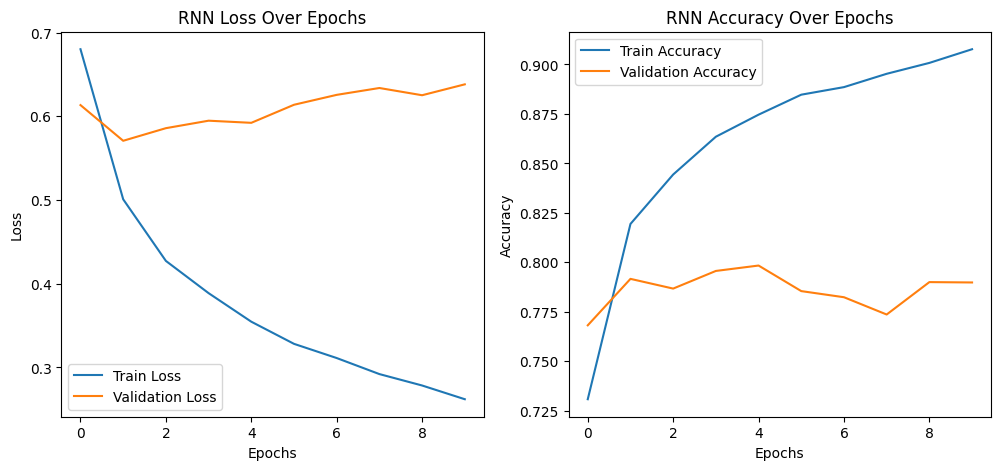

RNN Test Accuracy: 0.7898


In [ ]:
print(f"Training RNN model...")
startRNN = time.time()
modelRNN = build_RNN(128, 128, 0.3, 0.0005)
historyRNN = modelRNN.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
lossRNN, accuracyRNN = modelRNN.evaluate(X_test, y_test)
endRNN = time.time()
plotHist(historyRNN,'RNN')
print(f"RNN Test Accuracy: {accuracyRNN:.4f}")

In [ ]:
print(f"RNN Time : {endRNN-startRNN:.4f}")

RNN Time : 287.4360


## LSTM

In [ ]:
def build_LSTM(embedding_dim, hidden_units, dropout_rate, learning_rate):
  model = Sequential()
  model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=50))
  model.add(LSTM(hidden_units, return_sequences=False))
  model.add(Dropout(dropout_rate))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
  return model

Training LSTM model...
Epoch 1/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 67s 94ms/step - accuracy: 0.3976 - loss: 1.0887 - val_accuracy: 0.4068 - val_loss: 1.0867
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 65s 94ms/step - accuracy: 0.4014 - loss: 1.0937 - val_accuracy: 0.4068 - val_loss: 1.0902
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 65s 95ms/step - accuracy: 0.3918 - loss: 1.0921 - val_accuracy: 0.4068 - val_loss: 1.0850
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - accuracy: 0.4062 - loss: 1.0886 - val_accuracy: 0.4068 - val_loss: 1.0873
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.4049 - loss: 1.0894 - val_accuracy: 0.4068 - val_loss: 1.0866
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 82s 96ms/step - accuracy: 0.4055 - loss: 1.0881 - val_accuracy: 0.4068 - val_loss: 1.0884
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 81s 95ms/step - accuracy: 0.3981 - loss: 1.0886 - val_accuracy: 0.4068 - val_loss: 1.0871
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 81s 94ms/step - accuracy: 0

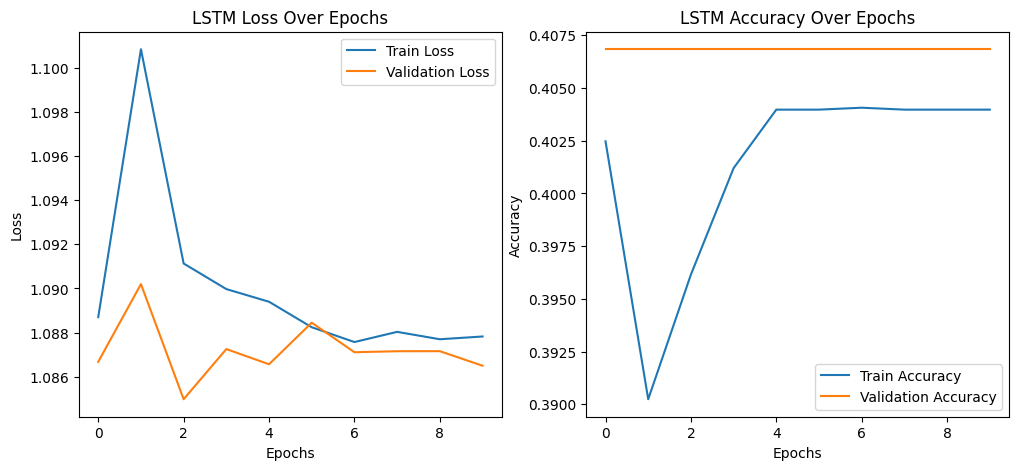

LSTM Time : 762.5153
LSTM Test Accuracy: 0.4068


In [ ]:
print(f"Training LSTM model...")
startLSTM = time.time()
modelLSTM = build_LSTM(embedding_dim=128, hidden_units=128, dropout_rate=0.3, learning_rate=0.0005)
historyLSTM = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
lossLSTM, accuracyLSTM = modelLSTM.evaluate(X_test, y_test)
endLSTM = time.time()
plotHist(historyLSTM,'LSTM')
print(f"LSTM Time : {endLSTM-startLSTM:.4f}")
print(f"LSTM Test Accuracy: {accuracyLSTM:.4f}")

## GRU

In [ ]:
def build_GRU(embedding_dim, hidden_units, dropout_rate, learning_rate):
  model = Sequential()
  model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=50))
  model.add(GRU(hidden_units, return_sequences=False))
  model.add(Dropout(dropout_rate))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
  return model

Training GRU model...
Epoch 1/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 114s 80ms/step - accuracy: 0.4045 - loss: 1.0896 - val_accuracy: 0.4068 - val_loss: 1.0865
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 84s 83ms/step - accuracy: 0.4054 - loss: 1.0875 - val_accuracy: 0.4068 - val_loss: 1.0867
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.4116 - loss: 1.0852 - val_accuracy: 0.4068 - val_loss: 1.0867
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - accuracy: 0.3985 - loss: 1.0893 - val_accuracy: 0.4068 - val_loss: 1.0867
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.4030 - loss: 1.0883 - val_accuracy: 0.4068 - val_loss: 1.0867
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.4036 - loss: 1.0880 - val_accuracy: 0.4068 - val_loss: 1.0869
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step - accuracy: 0.3988 - loss: 1.0888 - val_accuracy: 0.4068 - val_loss: 1.0877
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0

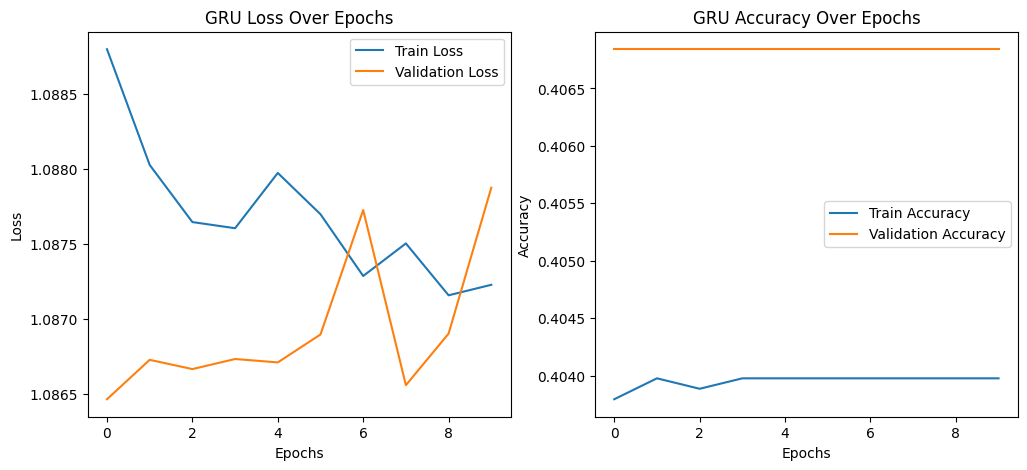

GRU Time : 801.9876
GRU Test Accuracy: 0.4068


In [ ]:
print(f"Training GRU model...")
startGRU = time.time()
modelGRU = build_GRU(embedding_dim=128, hidden_units=128, dropout_rate=0.3, learning_rate=0.0005)
historyGRU = modelGRU.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
lossGRU, accuracyGRU = modelGRU.evaluate(X_test, y_test)
endGRU = time.time()
plotHist(historyGRU,'GRU')
print(f"GRU Time : {endGRU-startGRU:.4f}")
print(f"GRU Test Accuracy: {accuracyGRU:.4f}")